In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

2025-06-29 17:40:11.545446: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751218811.849438      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751218811.940070      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	dff = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(dff.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(dff.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 

In [3]:
from tensorflow.keras.models import load_model


gru = load_model('/kaggle/input/demomodel-temp-mois/tensorflow2/default/1/gru.h5')
lstm = load_model('/kaggle/input/demomodel-temp-mois/tensorflow2/default/1/lstm.h5')
import joblib

# Load the scaler
scaler = joblib.load('/kaggle/input/demomodel-temp-mois/tensorflow2/default/1/minmax_scaler.joblib')


2025-06-29 17:40:28.960018: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [4]:
df = pd.read_csv(
    '/kaggle/input/tempura/open-meteo-10.65N106.76E6m (1).csv',
    sep=',',
    skiprows=3,                
    parse_dates=['time'],     
    infer_datetime_format=True,
    low_memory=False,
    na_values=['nan', '?'],
    index_col='time'          
)
n_in=24
df= df.iloc[:, :2].last('1Y')
df=scaler.transform(df)
df=series_to_supervised(df,n_in,1)
df=df.values
size=df.shape[0]

/tmp/ipykernel_13/3706231010.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(
/tmp/ipykernel_13/3706231010.py:12: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  df= df.iloc[:, :2].last('1Y')
/tmp/ipykernel_13/3706231010.py:12: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df= df.iloc[:, :2].last('1Y')
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [5]:
df.shape

(2880, 50)

In [6]:
x=df[:,:n_in*2].reshape((size, n_in, 2))
y=df[:,n_in*2:]

In [7]:
gru_pred=gru.predict(x)
lstm_pred=lstm.predict(x)

90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


In [8]:
gru_pred

array([[0.4149952 , 0.7986603 ],
       [0.40277252, 0.8222804 ],
       [0.38384336, 0.8536765 ],
       ...,
       [0.5006451 , 0.7698418 ],
       [0.50580394, 0.7686579 ],
       [0.52786255, 0.7422966 ]], dtype=float32)

In [9]:
lstm_pred

array([[0.41016898, 0.8766676 ],
       [0.39521003, 0.9002599 ],
       [0.38530767, 0.9341143 ],
       ...,
       [0.53078586, 0.7965087 ],
       [0.51895964, 0.79856926],
       [0.5118251 , 0.7768752 ]], dtype=float32)

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

def compare_pred_true_tables(pred_table, true_table, time_steps_to_plot,
                              title="Predicted vs True Values",
                              labels=("Temperature", "Moisture"),
                              scaler=None,
                              figsize=(16, 6),
                              linewidth=2,
                              fontsize=14):

    pred_table = np.array(pred_table)
    true_table = np.array(true_table)


    if scaler is not None:
        # Pad with zeros for inverse_transform
        dummy_pred = np.zeros((pred_table.shape[0], scaler.n_features_in_))
        dummy_true = np.zeros((true_table.shape[0], scaler.n_features_in_))
        dummy_pred[:, :pred_table.shape[1]] = pred_table
        dummy_true[:, :true_table.shape[1]] = true_table
        
    for i, name in enumerate(labels):
        y_true = dummy_true[:, i]
        y_pred = dummy_pred[:, i]

        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        rrse = np.sqrt(np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))
        print(f"{name} Metrics:")
        print(f"  MAE :  {mae:.4f}")
        print(f"  MSE :  {mse:.4f}")
        print(f"  RMSE:  {rmse:.4f}")
        print(f"  RRSE:  {rrse:.4f}")
    pred_table = scaler.inverse_transform(dummy_pred)[:, :pred_table.shape[1]]
    true_table = scaler.inverse_transform(dummy_true)[:, :true_table.shape[1]]
    # Time axis ( hourly)
    time_steps = np.arange(time_steps_to_plot)

    # Set global style
    plt.style.use('seaborn-whitegrid')

    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle(title, fontsize=fontsize + 2, weight='bold')

    # Color palette: [true colors, predicted colors]
    true_colors = ['#1b9e77', '#7570b3']      # green, purple
    pred_colors = ['#e41a1c', '#d95f02']      # red, orange

    for i, ax in enumerate(axes):
        ax.plot(time_steps, true_table[:time_steps_to_plot, i],
                label=f"True {labels[i]}",
                color=true_colors[i], linewidth=linewidth)

        ax.plot(time_steps, pred_table[:time_steps_to_plot, i],
                label=f"Predicted {labels[i]}",
                color=pred_colors[i], linestyle='--', linewidth=linewidth)

        ax.set_title(f"{labels[i]} Comparison", fontsize=fontsize, weight='semibold')
        ax.set_xlabel("Time Step (Hourly)", fontsize=fontsize)
        ax.set_ylabel(labels[i], fontsize=fontsize)
        ax.tick_params(axis='both', labelsize=fontsize - 2)
        ax.grid(True, linestyle='--', alpha=0.5)
        ax.legend(fontsize=fontsize - 2, loc="upper right")
        ax.set_xlim([0, time_steps_to_plot])

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


Temperature Metrics:
  MAE :  0.0228
  MSE :  0.0010
  RMSE:  0.0312
  RRSE:  0.2095
Moisture Metrics:
  MAE :  0.0299
  MSE :  0.0020
  RMSE:  0.0448
  RRSE:  0.2131


/tmp/ipykernel_13/787644254.py:43: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


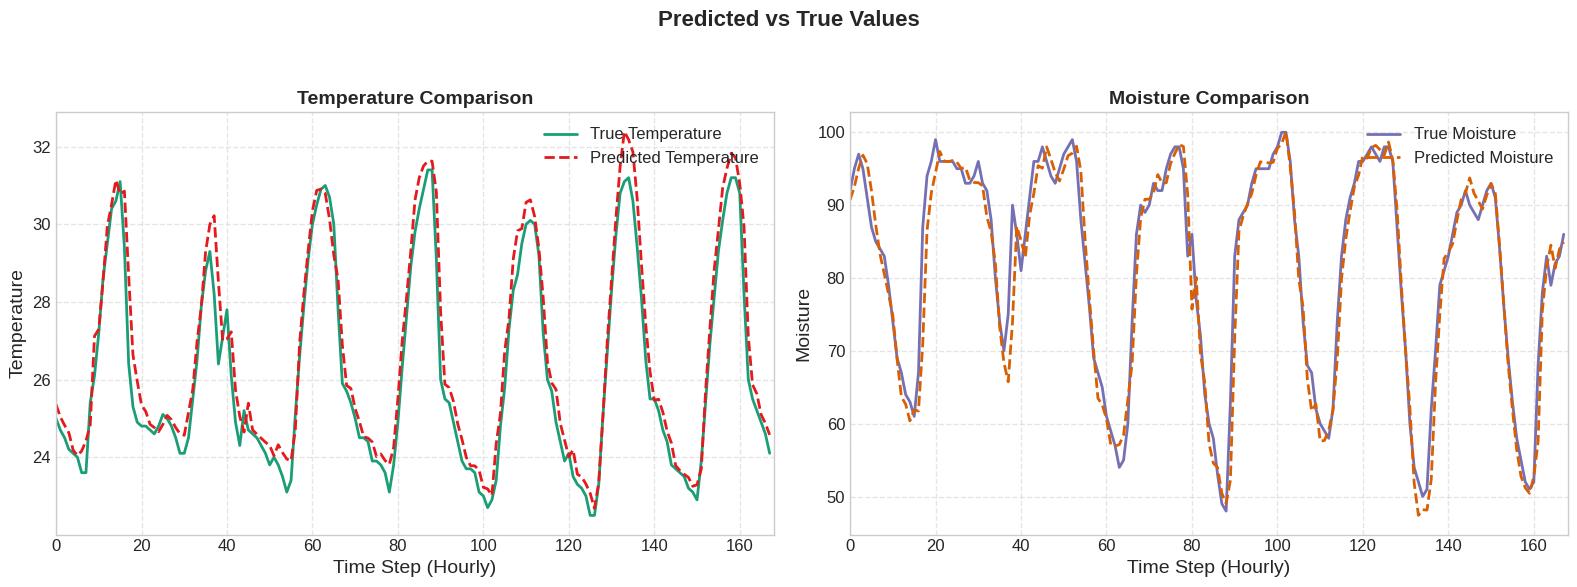

In [11]:
compare_pred_true_tables(lstm_pred,y,24*7,scaler=scaler)

Temperature Metrics:
  MAE :  0.0371
  MSE :  0.0024
  RMSE:  0.0491
  RRSE:  0.3298
Moisture Metrics:
  MAE :  0.0589
  MSE :  0.0054
  RMSE:  0.0736
  RRSE:  0.3501


/tmp/ipykernel_13/787644254.py:43: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


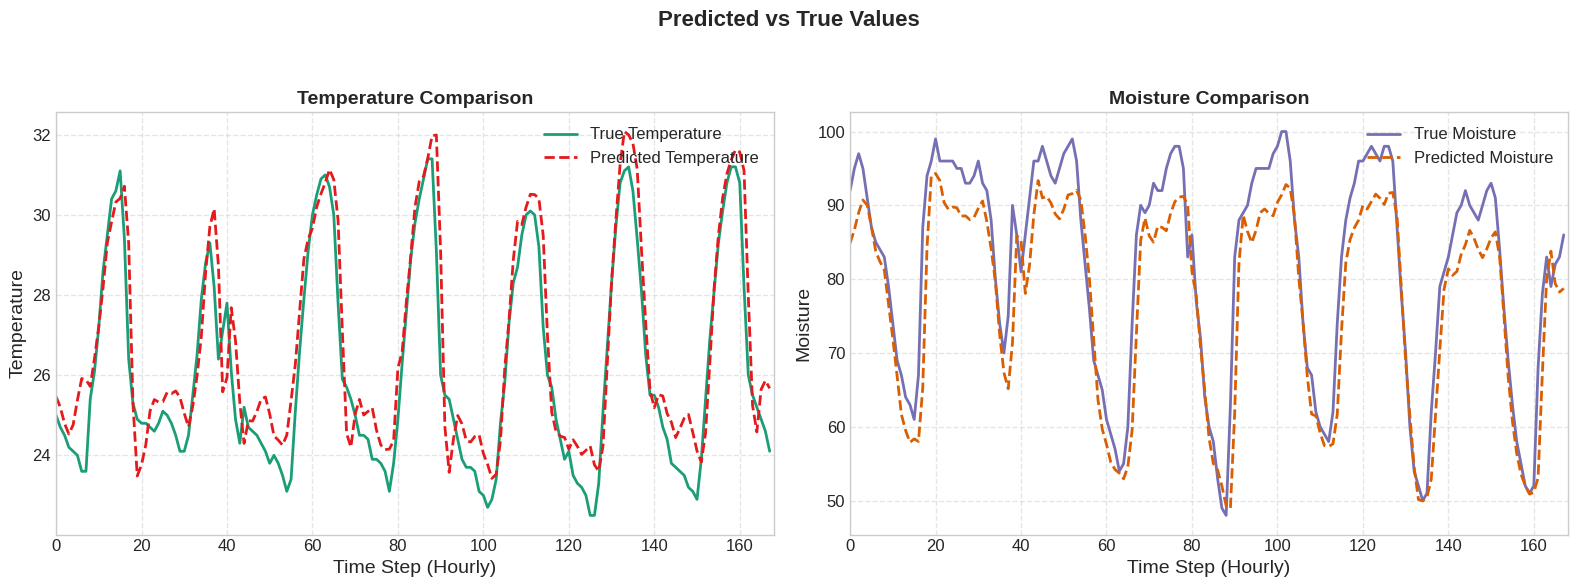

In [12]:
compare_pred_true_tables(gru_pred,y,24*7,scaler=scaler)